# To test the output of the GUI

# num_qubits = 1, dim_x = 1, dim_alpha =1-2; Rz(alpha) vs Rz(alpha)Rz(-alpha)Rz(alpha)

## Rz(alpha) part 1 output

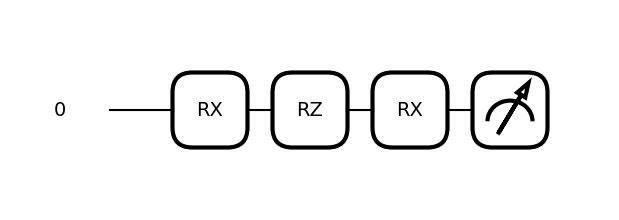

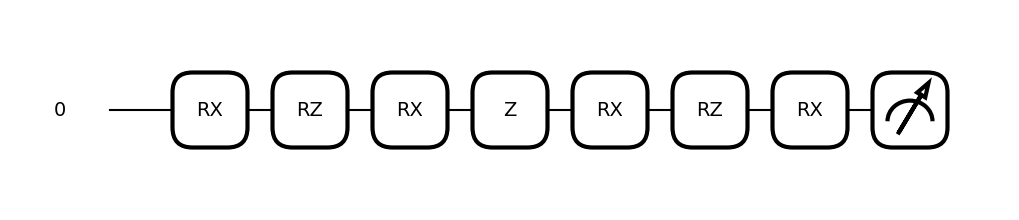

In [1]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 1
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[0], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## Rz(alpha) part 2 output

Kernel Matrix from Code:
[[1.         0.18727707 0.81941977]
 [0.18836174 1.         0.62533475]
 [0.81955205 0.62512278 1.        ]]
Theory Normalized kernel matrix:
[[1.         0.18830795 0.81911824]
 [0.18830795 1.         0.62480814]
 [0.81911824 0.62480814 1.        ]]


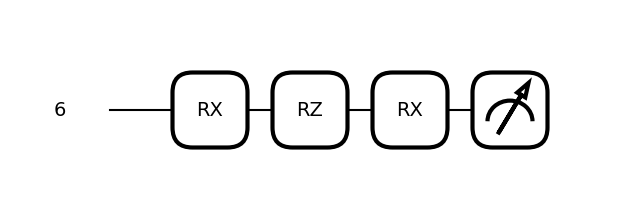

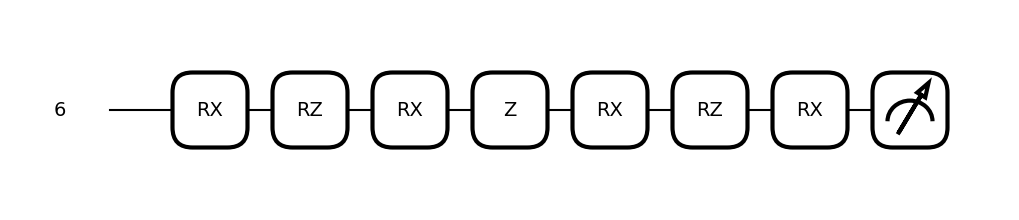

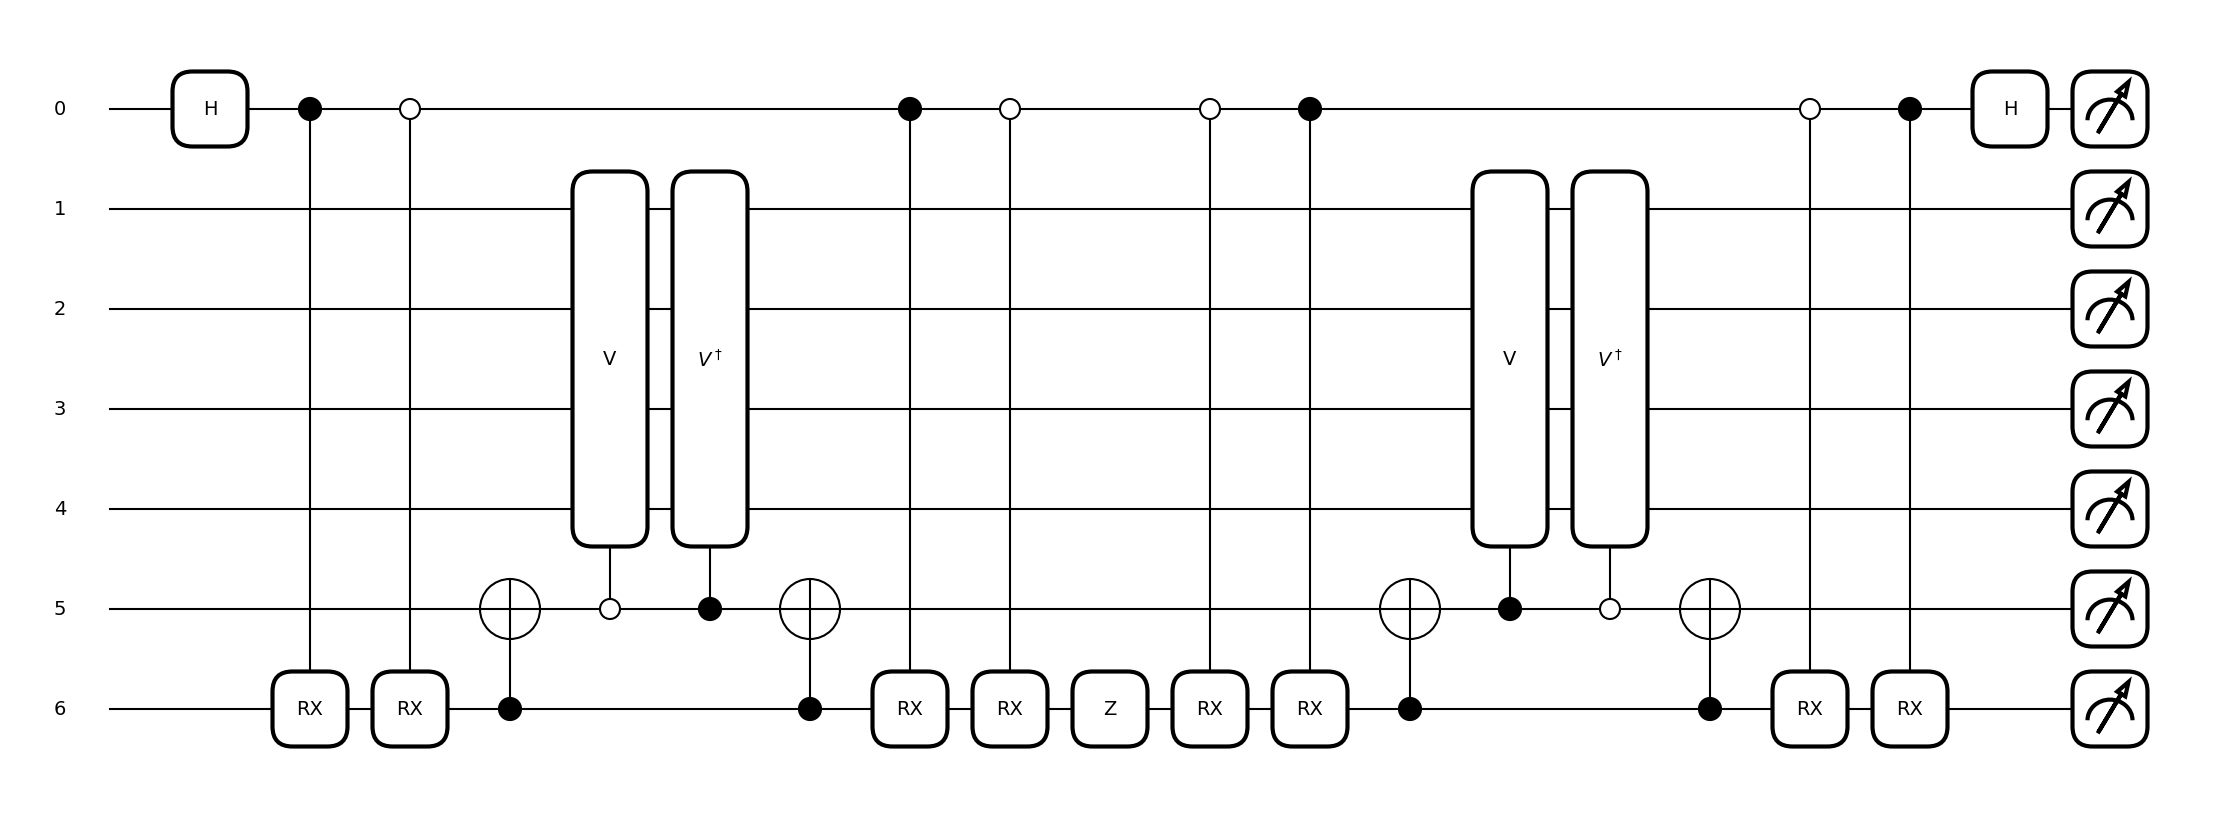

In [ ]:
import pennylane as qml
import numpy as np


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)


    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=1
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 4}; n_freq=4
n_anc=1; n_circ=1; n_total=7
kernel_offset=0; freq_offset=1
anc_offset=5; circ_offset=6
shots = 1000000

dev=qml.device('default.qubit', wires=n_total, shots = shots)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)
    # build P on shifted observables
    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+6}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[0], wires=6)
    qml.RZ(-α[0], wires=6)
    qml.RX(-x[0], wires=6)
    return qml.expval(P)

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [0])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [1])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)

    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+6}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [1])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [0])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);


def conditional_Z_kernel(x, x1, α):
    # shots = 10000
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # wire 4
    circ = samples[:, circ_offset]         # wire 5

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

def compute_kernel_matrix(X, α):
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            res = conditional_Z_kernel(X[i], X[j], α)

            # Store expectation (or 0 if no successful post-selection)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

            # # Print diagnostics
            # print(f"({i}, {j})")
            # print(f"  total shots:     {res['total_shots']}")
            # print(f"  kept shots:      {res['kept_shots']}")
            # print(f"  fraction kept:   {res['fraction_kept']:.6f}")
            # print(f"  expectation:     {res['expectation']}")
            # print()
    return K

X = [np.array([0.0]), np.array([1.2]), np.array([-0.7])]
α = np.array([0.5])

K = compute_kernel_matrix(X, α)
print("Kernel Matrix from Code:")
print(K)

def kernel_b_norm(x, x1):
    num = 2*(np.cos(x)**2 * np.cos(x1)**2 + 0.5 * np.sin(x)**2 * np.sin(x1)**2)
    denom = np.cos(x)**4 + np.cos(x1)**4 +0.5*(np.sin(x)**4 + np.sin(x1)**4)
    return num / denom

X = [0.0, 1.2, -0.7]
n = len(X)
K2 = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        K2[i, j] = kernel_b_norm(X[i], X[j])

print("Theory Normalized kernel matrix:")
print(K2)


## Rz(alpha)Rz(-alpha)Rz(alpha) part 1 output

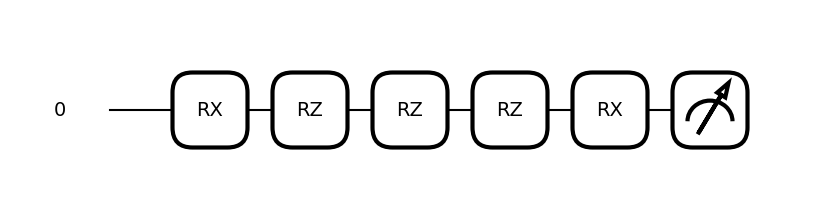

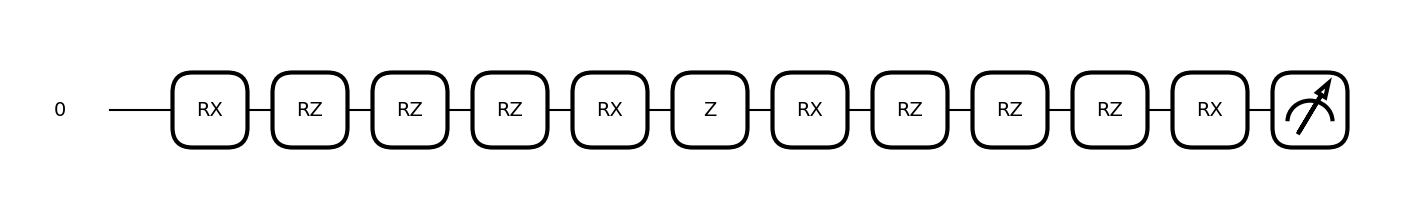

In [3]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 2
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RZ(α[1], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RZ(α[1], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[0], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RZ(-α[1], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## Rz(alpha)Rz(-alpha)Rz(alpha) part 2 output

Kernel Matrix from Code:
[[1.         0.19017454 0.81924392]
 [0.18708137 1.         0.62434643]
 [0.81880215 0.62562596 1.        ]]
Theory Normalized kernel matrix:
[[1.         0.18830795 0.81911824]
 [0.18830795 1.         0.62480814]
 [0.81911824 0.62480814 1.        ]]


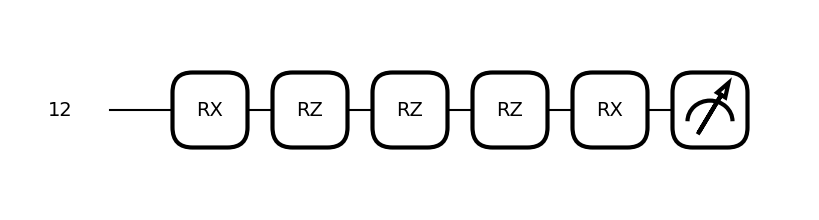

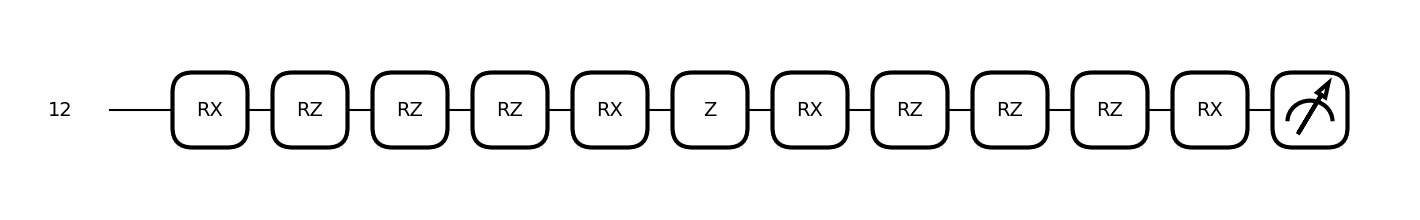

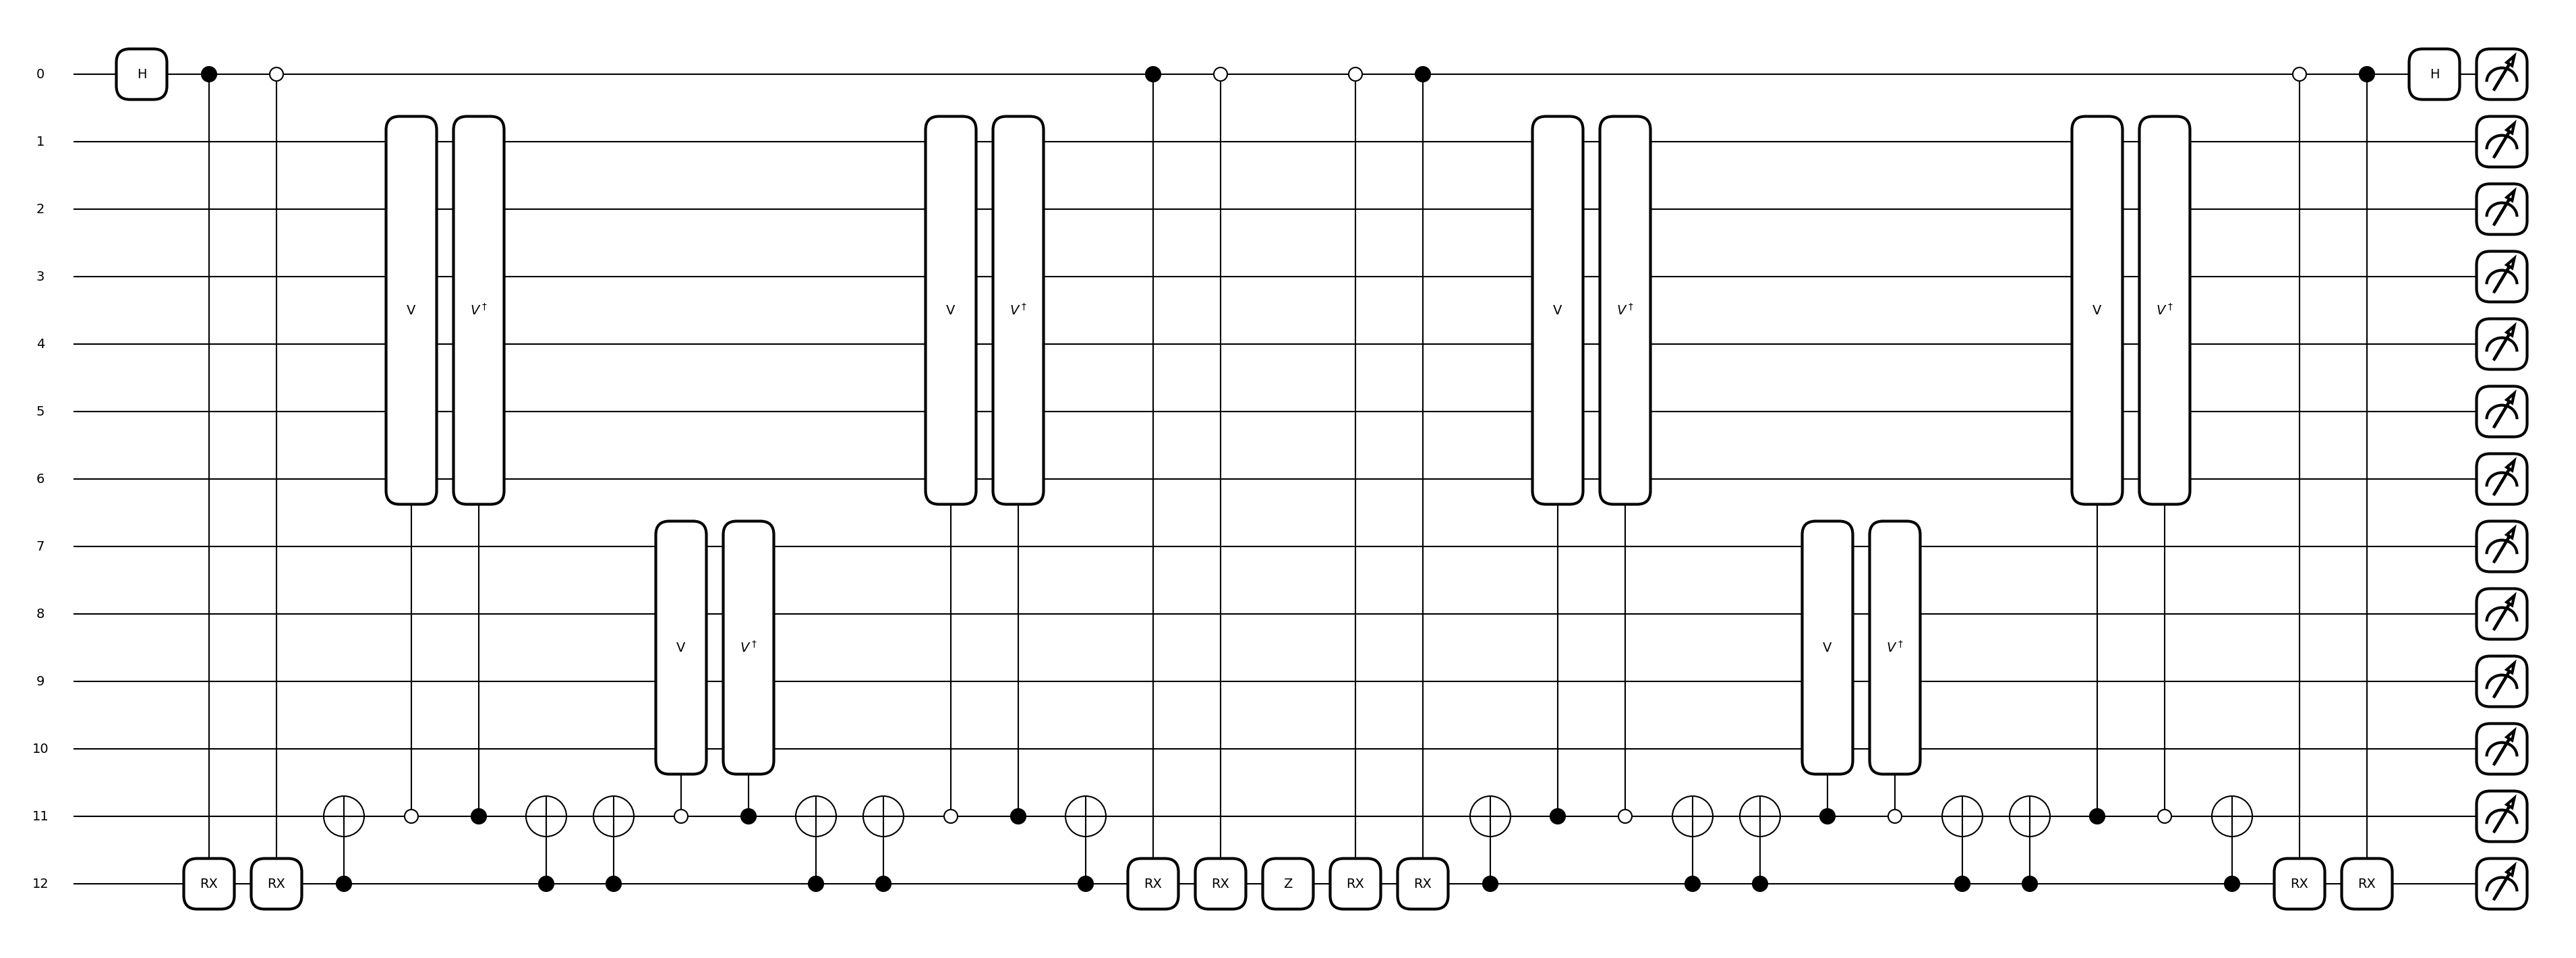

In [17]:
import pennylane as qml
import numpy as np


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)


    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=2
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 6, 1: 4}; n_freq=10
n_anc=1; n_circ=1; n_total=13
kernel_offset=0; freq_offset=1
anc_offset=11; circ_offset=12
shots = 1000000

dev=qml.device('default.qubit', wires=n_total, shots = shots)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RZ(α[1], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RX(x[0], wires=12)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RZ(α[1], wires=12)
    qml.RZ(α[0], wires=12)
    qml.RX(x[0], wires=12)
    # build P on shifted observables
    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+12}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[0], wires=12)
    qml.RZ(-α[0], wires=12)
    qml.RZ(-α[1], wires=12)
    qml.RZ(-α[0], wires=12)
    qml.RX(-x[0], wires=12)
    return qml.state()

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=12)
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[7, 8, 9, 10], mod=2**4)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[7, 8, 9, 10], mod=2**4)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [0])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [1])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=12)

    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+12}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=12)
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[7, 8, 9, 10], mod=2**4)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[7, 8, 9, 10], mod=2**4)
    qml.CNOT(wires=(12,11))
    qml.CNOT(wires=(12,11))
    qml.ctrl(V, control = 11, control_values = [1])( value = 1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.ctrl(Vdagger, control = 11, control_values = [0])( value = -1, wires=[1, 2, 3, 4, 5, 6], mod=2**6)
    qml.CNOT(wires=(12,11))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=12)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=12)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);


def conditional_Z_kernel(x, x1, α):
    # shots = 10000
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # wire 4
    circ = samples[:, circ_offset]         # wire 5

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

def compute_kernel_matrix(X, α):
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            res = conditional_Z_kernel(X[i], X[j], α)

            # Store expectation (or 0 if no successful post-selection)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

            # # Print diagnostics
            # print(f"({i}, {j})")
            # print(f"  total shots:     {res['total_shots']}")
            # print(f"  kept shots:      {res['kept_shots']}")
            # print(f"  fraction kept:   {res['fraction_kept']:.6f}")
            # print(f"  expectation:     {res['expectation']}")
            # print()
    return K

X = [np.array([0.0]), np.array([1.2]), np.array([-0.7])]
α = np.array([0.5])

K = compute_kernel_matrix(X, α)
print("Kernel Matrix from Code:")
print(K)

def kernel_b_norm(x, x1):
    num = 2*(np.cos(x)**2 * np.cos(x1)**2 + 0.5 * np.sin(x)**2 * np.sin(x1)**2)
    denom = np.cos(x)**4 + np.cos(x1)**4 +0.5*(np.sin(x)**4 + np.sin(x1)**4)
    return num / denom

X = [0.0, 1.2, -0.7]
n = len(X)
K2 = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        K2[i, j] = kernel_b_norm(X[i], X[j])

print("Theory Normalized kernel matrix:")
print(K2)


# Testing Kernel Ridge Regression

## dim_x = 2 part 1 output

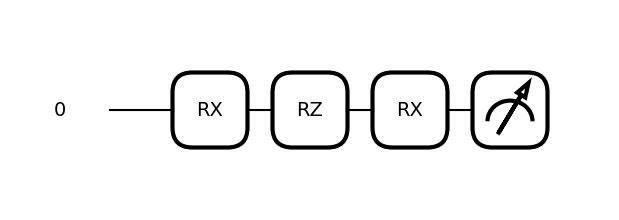

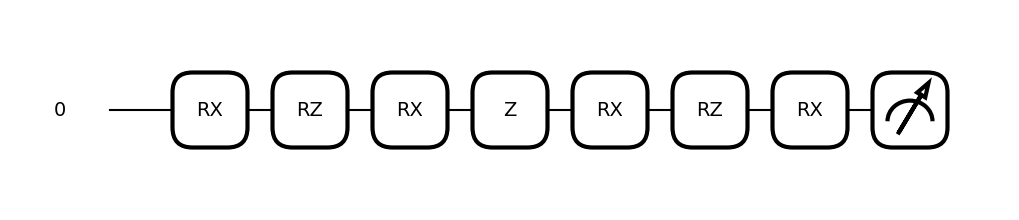

In [20]:
import pennylane as qml
import numpy as np

dim_x = 2
dim_alpha = 1
observable_terms = ['Z0']

def build_P(observable_terms):
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[1], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[1], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[1], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## dim_x = 2 part 2 output

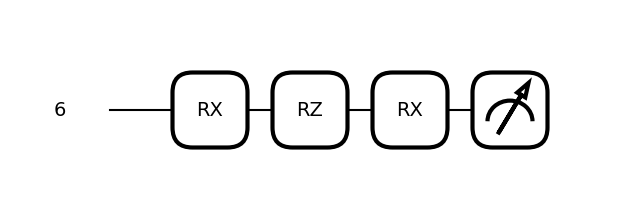

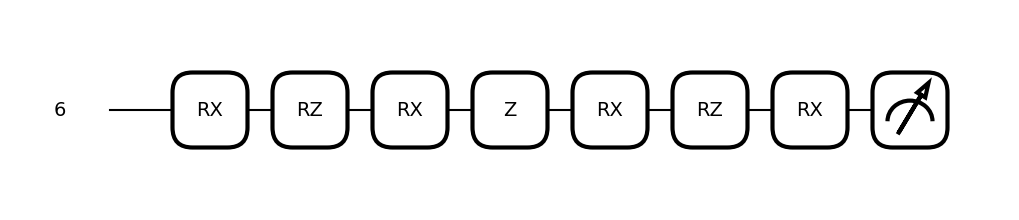

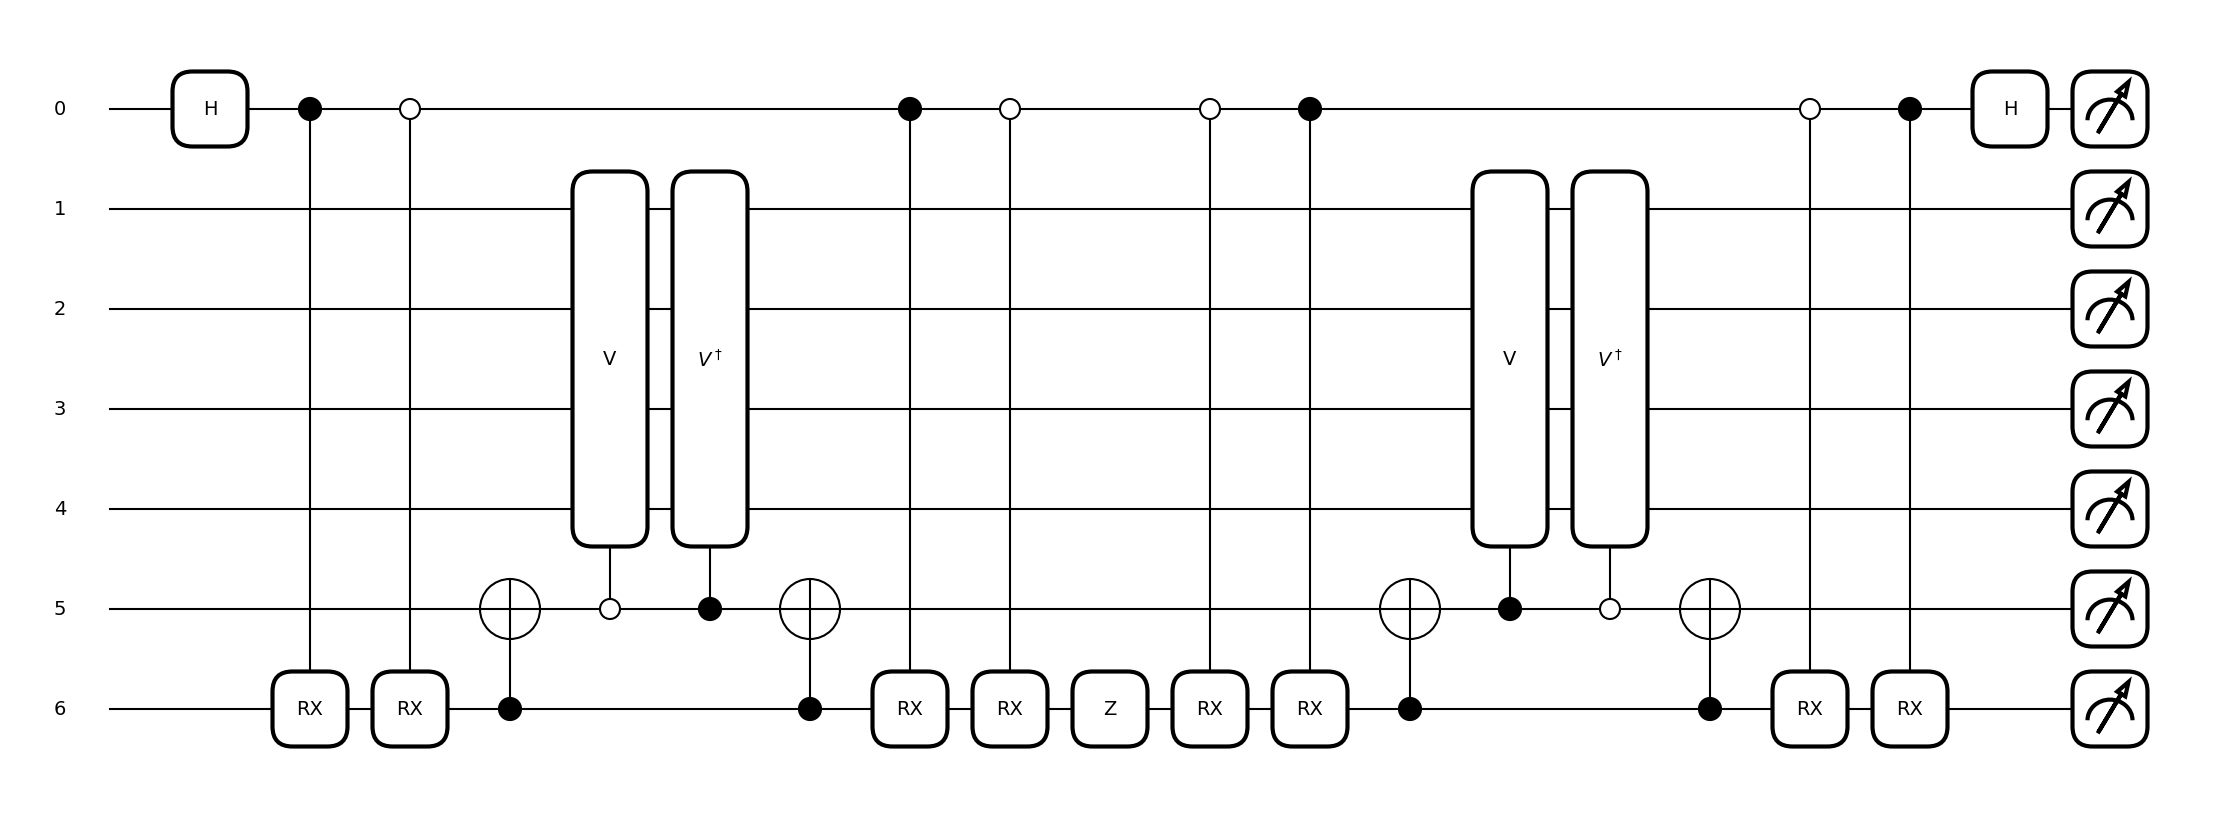

Computing train kernel: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]



Time to compute TRAIN kernel = 0.591 seconds



Computing test kernel: 100%|██████████| 2/2 [00:00<00:00, 15.30it/s]
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



Time to compute TEST kernel = 0.133 seconds

Time for Kernel Ridge Regression fit = 0.001 seconds

Train MSE = 1.9831034630710335e-05
Test MSE  = 0.006994560828363623
Train R2 = 0.999890122441736
Test R2  = 0.9772362534486198

Train Kernel:
[[1.         0.9231262  0.92813853 0.945262   0.67725828 0.98934797
  0.9644901  0.98440312]
 [0.93092021 1.         0.72392904 0.99853126 0.43640972 0.97107977
  0.98978799 0.83557839]
 [0.92790102 0.73316099 1.         0.77911833 0.89497332 0.86895893
  0.81811989 0.97136038]
 [0.95168817 0.99811123 0.76865439 1.         0.47141488 0.98539778
  0.99557574 0.87446715]
 [0.69927863 0.45318127 0.89059923 0.47216429 1.         0.59297686
  0.51869806 0.80610134]
 [0.99032882 0.96494137 0.87586985 0.98117942 0.6080265  1.
  0.99361447 0.948618  ]
 [0.9687043  0.99156586 0.80924557 0.99765396 0.52424137 0.99417064
  1.         0.90881361]
 [0.98667451 0.84427355 0.98148148 0.87984611 0.79850554 0.9453303
  0.91494804 1.        ]]
Train-Test Kernel:
[[0

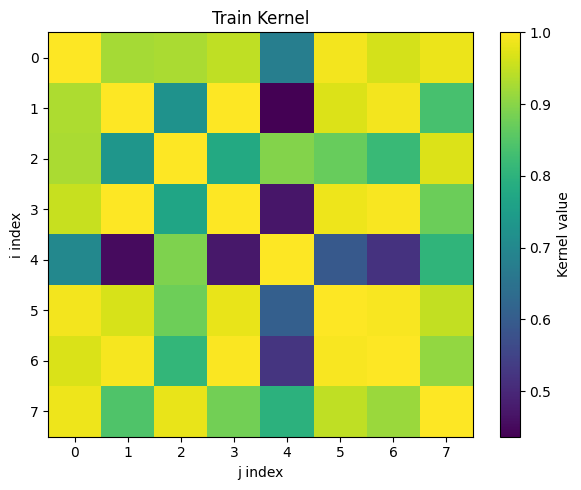

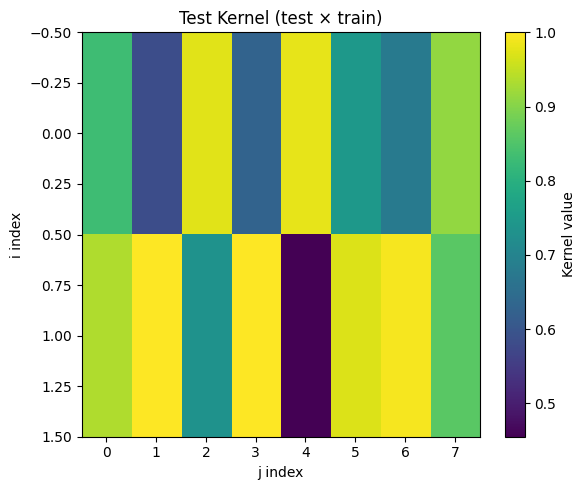

In [21]:
import pennylane as qml
import numpy as np


from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score


SEED = 42
np.random.seed(SEED)


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)

    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=2
dim_alpha=1
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 4}; n_freq=4
n_anc=1; n_circ=1; n_total=7
kernel_offset=0; freq_offset=1
anc_offset=5; circ_offset=6
shots = 10000

dev=qml.device('default.qubit', wires=n_total, shots = shots, seed = SEED)
dev_analytic = qml.device('default.qubit', wires=n_total, shots=None)  # analytic

P_shifted = build_shifted_P(observable_terms, circ_offset=circ_offset)

def U(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[1], wires=6)

@qml.qnode(dev_analytic)
def U_return_expval(x, α):
    U(x,α)
    return qml.expval(P_shifted)

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[1], wires=6)
    P = build_shifted_P(observable_terms,circ_offset)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[1], wires=6)
    qml.RZ(-α[0], wires=6)
    qml.RX(-x[0], wires=6)
    return qml.state()

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [0])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [1])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[1], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[1], wires=6)
    P = build_shifted_P(observable_terms,circ_offset)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[1], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[1], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [1])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [0])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U_return_expval)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);
plt.show();


def conditional_Z_kernel(x, x1, α):
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # anc wire
    circ = samples[:, circ_offset]         # circ wire

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

# -------------------------------------------------------
# Generate dataset
# -------------------------------------------------------
def generate_labels(X, α):
    Y = np.array([U_return_expval(x_arr, α) for x_arr in X])
    return Y


# Generated X (list of numpy arrays):
X = [np.array([0.0, 0.0]), np.array([0.1111111111111111, 0.1111111111111111]), np.array([0.2222222222222222, 0.2222222222222222]), np.array([0.3333333333333333, 0.3333333333333333]), np.array([0.4444444444444444, 0.4444444444444444]), np.array([0.5555555555555556, 0.5555555555555556]), np.array([0.6666666666666666, 0.6666666666666666]), np.array([0.7777777777777777, 0.7777777777777777]), np.array([0.8888888888888888, 0.8888888888888888]), np.array([1.0, 1.0])]
alpha = np.array([0.5])
Y = generate_labels(X,alpha)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = SEED)


if dim_x == 1:
    plt.plot(X, Y, ".-")
    plt.xlabel("x")
    plt.ylabel(r"$\langle 0 | U^{\dagger}(x,\alpha)\, P\, U(x,\alpha) | 0 \rangle$")
    plt.show();


# -------------------------------------------------------
# FUNCTION — compute train kernel (precomputed kernel)
# -------------------------------------------------------
def compute_kernel_matrix_train(X_train, α):
    n = len(X_train)
    K = np.zeros((n, n))

    for i in tqdm(range(n), desc="Computing train kernel"):
        for j in range(n):
            res = conditional_Z_kernel(X_train[i], X_train[j], α)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

    return K


# -------------------------------------------------------
# FUNCTION — compute test kernel (test × train)
# -------------------------------------------------------
def compute_kernel_matrix_test(X_test, X_train, α):
    n_test = len(X_test)
    n_train = len(X_train)
    K = np.zeros((n_test, n_train))

    for i in tqdm(range(n_test), desc="Computing test kernel"):
        for j in range(n_train):
            res = conditional_Z_kernel(X_test[i], X_train[j], α)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

    return K

# -------------------------------------------------------
# KERNEL COMPUTATION WITH TIMING
# -------------------------------------------------------
start_train = time.time()
K_train = compute_kernel_matrix_train(X_train, alpha)
end_train = time.time()
print(f"\nTime to compute TRAIN kernel = {end_train - start_train:.3f} seconds\n")

start_test = time.time()
K_test = compute_kernel_matrix_test(X_test, X_train, alpha)
end_test = time.time()
print(f"\nTime to compute TEST kernel = {end_test - start_test:.3f} seconds\n")



# -------------------------------------------------------
# KERNEL RIDGE REGRESSION
# -------------------------------------------------------
start_krr = time.time()
krr = KernelRidge(alpha=1e-3, kernel='precomputed')
krr.fit(K_train, Y_train)
end_krr = time.time()
print(f"Time for Kernel Ridge Regression fit = {end_krr - start_krr:.3f} seconds\n")

Y_train_pred = krr.predict(K_train)
Y_test_pred = krr.predict(K_test)

# -------------------------------------------------------
# METRICS
# -------------------------------------------------------
print("Train MSE =", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE  =", mean_squared_error(Y_test, Y_test_pred))

print("Train R2 =", r2_score(Y_train, Y_train_pred))
print("Test R2  =", r2_score(Y_test, Y_test_pred))

# -------------------------------------------------------
# KERNELS
# -------------------------------------------------------
print("")
print("Train Kernel:")
print(K_train)
print("Train-Test Kernel:")
print(K_test)

def show_kernel_heatmap(K, title="Kernel Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(K, aspect='auto')
    plt.colorbar(label='Kernel value')
    plt.title(title)
    plt.xlabel("j index")
    plt.ylabel("i index")
    plt.tight_layout()
    plt.show()

show_kernel_heatmap(K_train, "Train Kernel")
show_kernel_heatmap(K_test, "Test Kernel (test × train)")
# -------------------------------------------------------
# PLOT RESULTS
# -------------------------------------------------------
if dim_x == 1:
    plt.figure(figsize=(10,5))
    plt.scatter([x[0] for x in X_train], Y_train, label="train true", alpha=0.8)
    plt.scatter([x[0] for x in X_train], Y_train_pred, label="train pred", alpha=0.8)

    plt.scatter([x[0] for x in X_test], Y_test, label="test true", alpha=0.8)
    plt.scatter([x[0] for x in X_test], Y_test_pred, label="test pred", alpha=0.8)

    plt.legend()
    plt.xlabel("x")
    plt.ylabel(r"$\langle 0 | U^{\dagger}(x,\alpha)\, P\, U(x,\alpha) | 0 \rangle$")
    plt.title("Kernel Ridge Regression using Quantum Kernel")
    plt.show()



## dim_x = 1 part 1 output

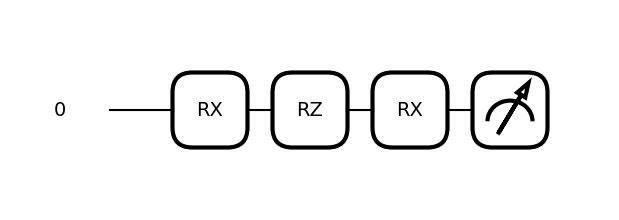

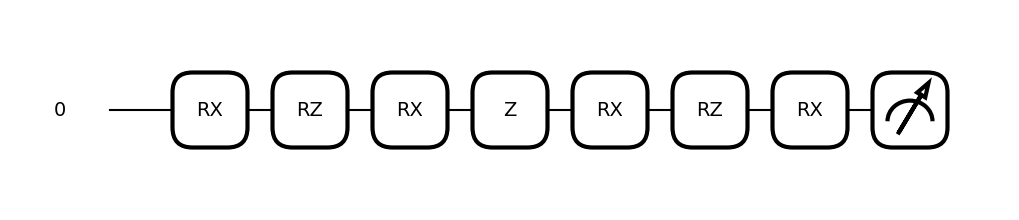

In [22]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 1
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=0)
    qml.RZ(α[0], wires=0)
    qml.RX(x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(-x[0], wires=0)
    qml.RZ(-α[0], wires=0)
    qml.RX(-x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## dim_x = 1 part 2 output

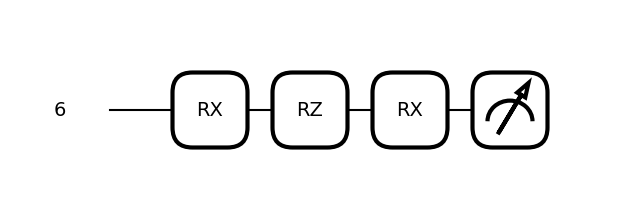

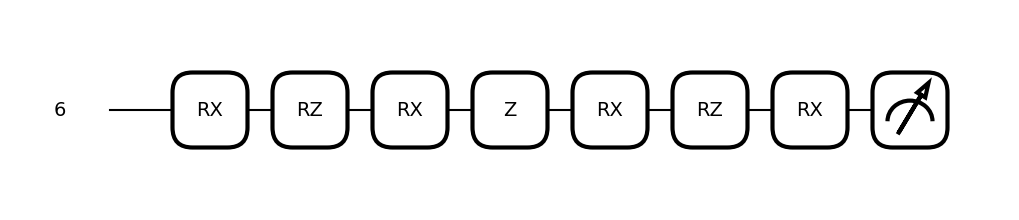

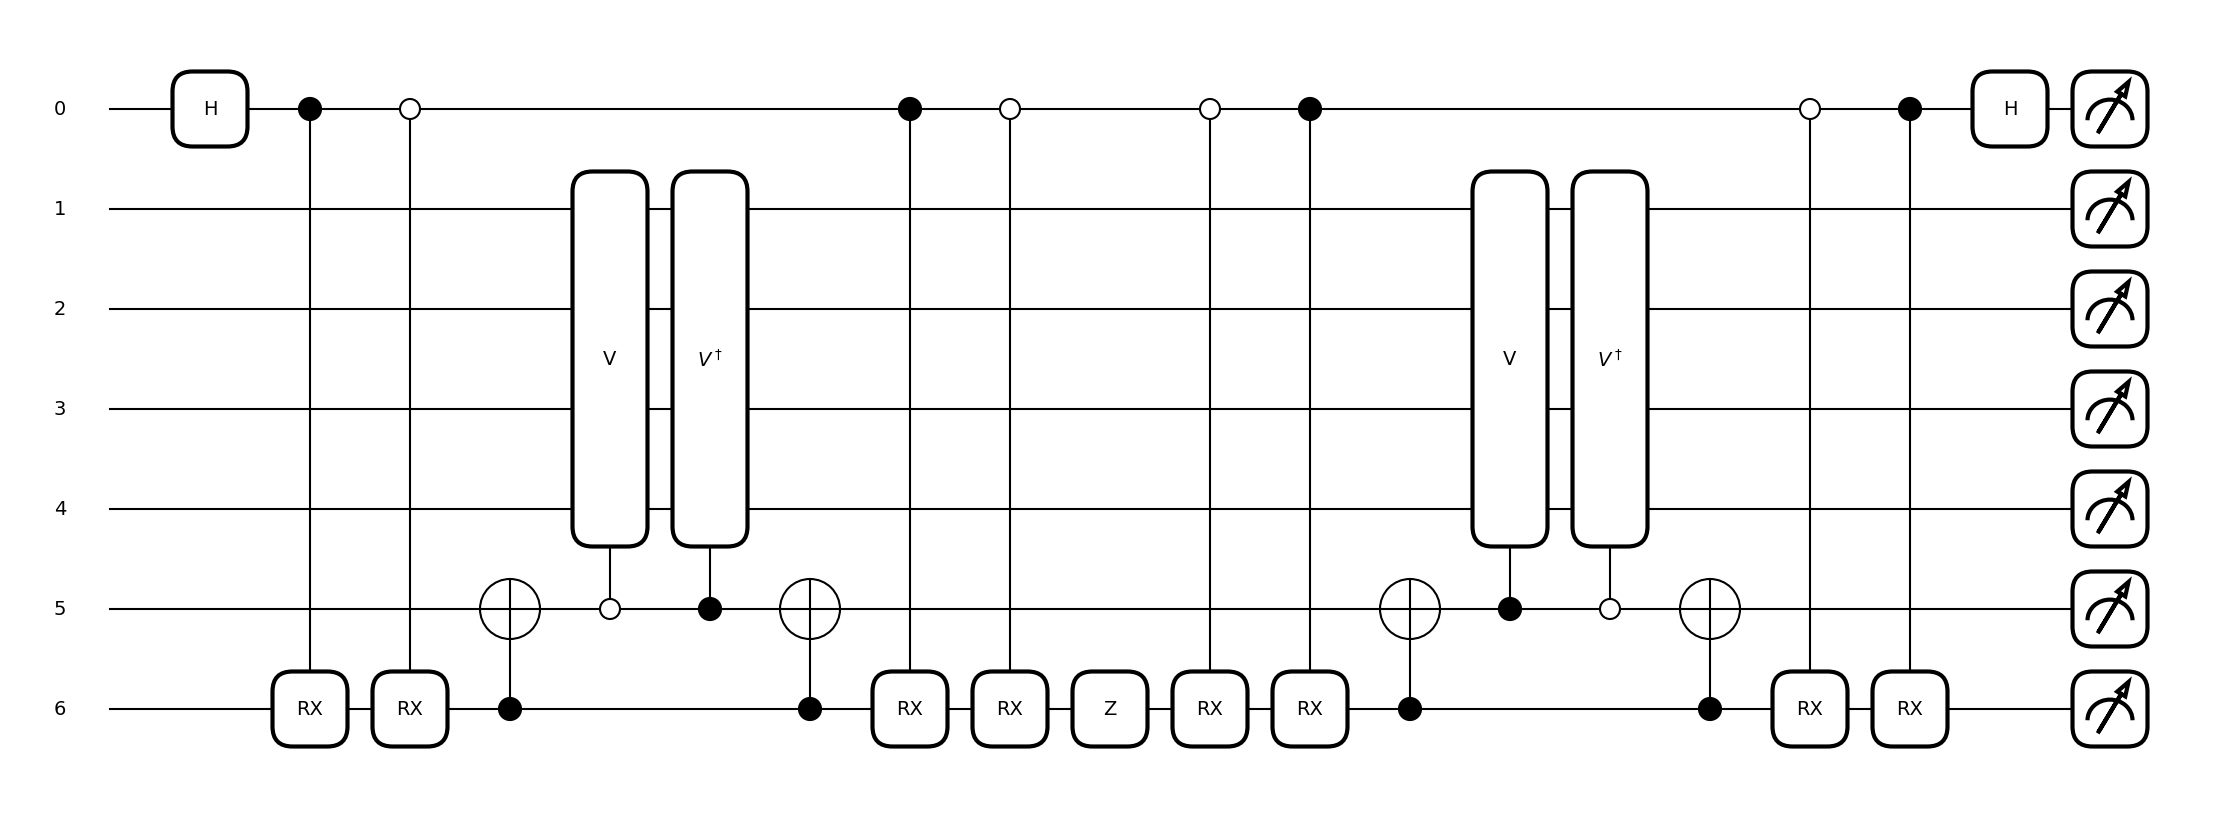

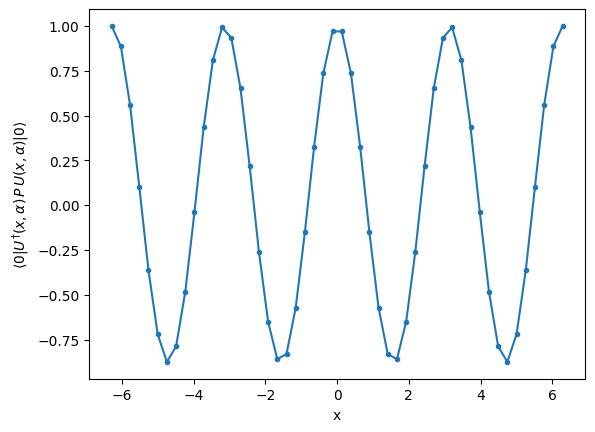

Computing train kernel: 100%|██████████| 40/40 [02:25<00:00,  3.63s/it]



Time to compute TRAIN kernel = 145.308 seconds



Computing test kernel: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


Time to compute TEST kernel = 37.334 seconds

Time for Kernel Ridge Regression fit = 0.001 seconds

Train MSE = 0.00015033653887333622
Test MSE  = 0.004755999401332662
Train R2 = 0.9996426486020346
Test R2  = 0.9915728203647012

Train Kernel:
[[1.         0.4140363  1.         ... 0.97049073 0.5824101  0.99213517]
 [0.41278806 1.         0.41301296 ... 0.57104976 0.97193059 0.49022185]
 [1.         0.411744   1.         ... 0.97070779 0.58428    0.99215759]
 ...
 [0.9704136  0.56963054 0.96996727 ... 1.         0.73230299 0.99296564]
 [0.58435541 0.97089419 0.58239134 ... 0.73229241 1.         0.66099274]
 [0.99225177 0.490713   0.99206348 ... 0.99276382 0.65917093 1.        ]]
Train-Test Kernel:
[[0.9992611  0.43449678 0.99930912 0.33848279 0.77623605 0.02816278
  0.33581872 0.77621047 0.96085243 0.83767697 0.68708248 0.52141907
  0.99966286 0.83822659 0.03885571 0.99898904 0.14373749 0.88967007
  0.52161974 0.14440908 0.26366607 0.99600323 1.         0.99944468
  0.60533874 0.960927


c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


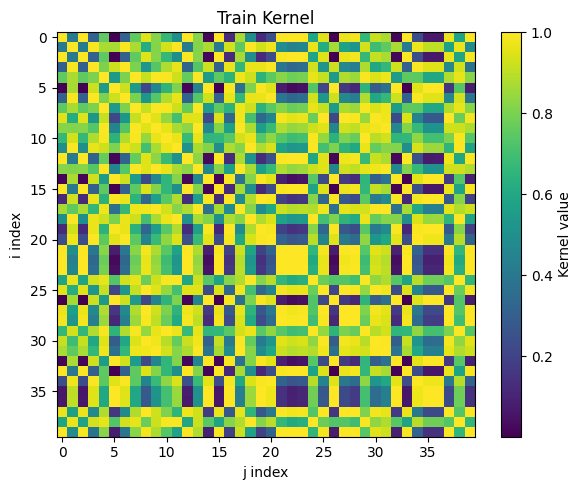

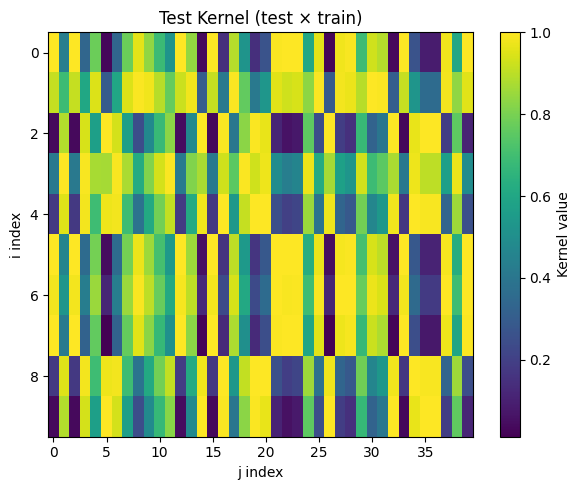

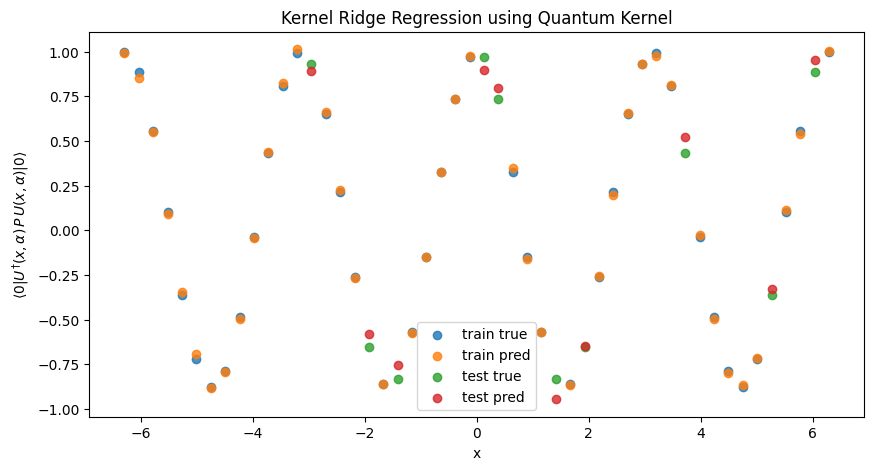

In [23]:
import pennylane as qml
import numpy as np


from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score


SEED = 42
np.random.seed(SEED)


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    num_params = 2
    par_domain = "R"
    def __init__(self, value, wires, mod):
        super().__init__(value, mod, wires=wires)

    def decomposition(self):
        # Actual gate: controlled Adder
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return [qml.Adder(self.parameters[0], x_wires=self.wires, mod=self.parameters[1])]
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=1
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 4}; n_freq=4
n_anc=1; n_circ=1; n_total=7
kernel_offset=0; freq_offset=1
anc_offset=5; circ_offset=6
shots = 1000000

dev=qml.device('default.qubit', wires=n_total, shots = shots, seed = SEED)
dev_analytic = qml.device('default.qubit', wires=n_total, shots=None)  # analytic

P_shifted = build_shifted_P(observable_terms, circ_offset=circ_offset)

def U(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)

@qml.qnode(dev_analytic)
def U_return_expval(x, α):
    U(x,α)
    return qml.expval(P_shifted)

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(x[0], wires=6)
    qml.RZ(α[0], wires=6)
    qml.RX(x[0], wires=6)
    P = build_shifted_P(observable_terms,circ_offset)
    # user-provided adjoint (trimmed prefix)
    qml.RX(-x[0], wires=6)
    qml.RZ(-α[0], wires=6)
    qml.RX(-x[0], wires=6)
    return qml.state()

def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [0])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [1])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[1])(x[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[0])(x1[0], wires=6)
    P = build_shifted_P(observable_terms,circ_offset)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.CNOT(wires=(6,5))
    qml.ctrl(V, control = 5, control_values = [1])( value = 1, wires=[1, 2, 3, 4], mod=2**4)
    qml.ctrl(Vdagger, control = 5, control_values = [0])( value = -1, wires=[1, 2, 3, 4], mod=2**4)
    qml.CNOT(wires=(6,5))
    qml.ctrl(qml.RX, control=0, control_values=[0])(-x1[0], wires=6)
    qml.ctrl(qml.RX, control=0, control_values=[1])(-x[0], wires=6)
    qml.Hadamard(wires=0)


@qml.qnode(dev)
def AuPAu_sample(x, x1, α):
    AuPAu(x, x1, α)   # run your circuit
    return qml.sample(wires=range(n_total))


# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U_return_expval)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu_sample)(x0, x1, α0);
plt.show();


def conditional_Z_kernel(x, x1, α):
    samples = AuPAu_sample(x, x1, α)

    # Extract each register
    kernel = samples[:, kernel_offset]     # wire 0
    anc = samples[:, anc_offset]           # anc wire
    circ = samples[:, circ_offset]         # circ wire

    # Condition: anc=0 and circ=0
    mask = (anc == 0) & (circ == 0)
    conditioned = kernel[mask]

    total = shots
    kept = conditioned.shape[0]

    if kept == 0:
        return {
            "total_shots": total,
            "kept_shots": 0,
            "expectation": None,
        }

    # convert bits to Z eigenvalues (+1 for 0, -1 for 1)
    zvals = 1 - 2*conditioned       # maps 0→+1, 1→−1

    return {
        "total_shots": total,
        "kept_shots": kept,
        "fraction_kept": kept / total,
        "expectation": np.mean(zvals),
    }

# -------------------------------------------------------
# Generate dataset
# -------------------------------------------------------
def generate_labels(X, α):
    Y = np.array([U_return_expval(x_arr, α) for x_arr in X])
    return Y


# Generated X (list of numpy arrays):
X = [np.array([-6.29]), np.array([-6.033265306122449]), np.array([-5.776530612244898]), np.array([-5.519795918367347]), np.array([-5.263061224489796]), np.array([-5.006326530612245]), np.array([-4.749591836734694]), np.array([-4.492857142857143]), np.array([-4.236122448979591]), np.array([-3.9793877551020405]), np.array([-3.7226530612244897]), np.array([-3.4659183673469385]), np.array([-3.2091836734693873]), np.array([-2.9524489795918365]), np.array([-2.6957142857142853]), np.array([-2.4389795918367345]), np.array([-2.1822448979591833]), np.array([-1.9255102040816325]), np.array([-1.6687755102040809]), np.array([-1.4120408163265301]), np.array([-1.1553061224489793]), np.array([-0.8985714285714277]), np.array([-0.6418367346938769]), np.array([-0.38510204081632615]), np.array([-0.1283673469387745]), np.array([0.12836734693877627]), np.array([0.38510204081632704]), np.array([0.6418367346938778]), np.array([0.8985714285714295]), np.array([1.1553061224489802]), np.array([1.412040816326531]), np.array([1.6687755102040827]), np.array([1.9255102040816334]), np.array([2.182244897959184]), np.array([2.438979591836735]), np.array([2.6957142857142857]), np.array([2.9524489795918383]), np.array([3.209183673469389]), np.array([3.46591836734694]), np.array([3.7226530612244906]), np.array([3.9793877551020413]), np.array([4.236122448979592]), np.array([4.492857142857145]), np.array([4.749591836734695]), np.array([5.006326530612246]), np.array([5.263061224489797]), np.array([5.519795918367348]), np.array([5.7765306122448985]), np.array([6.033265306122451]), np.array([6.29])]
alpha = np.array([0.5])
Y = generate_labels(X,alpha)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = SEED)


if dim_x == 1:
    plt.plot(X, Y, ".-")
    plt.xlabel("x")
    plt.ylabel(r"$\langle 0 | U^{\dagger}(x,\alpha)\, P\, U(x,\alpha) | 0 \rangle$")
    plt.show();


# -------------------------------------------------------
# FUNCTION — compute train kernel (precomputed kernel)
# -------------------------------------------------------
def compute_kernel_matrix_train(X_train, α):
    n = len(X_train)
    K = np.zeros((n, n))

    for i in tqdm(range(n), desc="Computing train kernel"):
        for j in range(n):
            res = conditional_Z_kernel(X_train[i], X_train[j], α)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

    return K


# -------------------------------------------------------
# FUNCTION — compute test kernel (test × train)
# -------------------------------------------------------
def compute_kernel_matrix_test(X_test, X_train, α):
    n_test = len(X_test)
    n_train = len(X_train)
    K = np.zeros((n_test, n_train))

    for i in tqdm(range(n_test), desc="Computing test kernel"):
        for j in range(n_train):
            res = conditional_Z_kernel(X_test[i], X_train[j], α)
            K[i, j] = res["expectation"] if res["expectation"] is not None else 0.0

    return K

# -------------------------------------------------------
# KERNEL COMPUTATION WITH TIMING
# -------------------------------------------------------
start_train = time.time()
K_train = compute_kernel_matrix_train(X_train, alpha)
end_train = time.time()
print(f"\nTime to compute TRAIN kernel = {end_train - start_train:.3f} seconds\n")

start_test = time.time()
K_test = compute_kernel_matrix_test(X_test, X_train, alpha)
end_test = time.time()
print(f"\nTime to compute TEST kernel = {end_test - start_test:.3f} seconds\n")



# -------------------------------------------------------
# KERNEL RIDGE REGRESSION
# -------------------------------------------------------
start_krr = time.time()
krr = KernelRidge(alpha=1e-3, kernel='precomputed')
krr.fit(K_train, Y_train)
end_krr = time.time()
print(f"Time for Kernel Ridge Regression fit = {end_krr - start_krr:.3f} seconds\n")

Y_train_pred = krr.predict(K_train)
Y_test_pred = krr.predict(K_test)

# -------------------------------------------------------
# METRICS
# -------------------------------------------------------
print("Train MSE =", mean_squared_error(Y_train, Y_train_pred))
print("Test MSE  =", mean_squared_error(Y_test, Y_test_pred))

print("Train R2 =", r2_score(Y_train, Y_train_pred))
print("Test R2  =", r2_score(Y_test, Y_test_pred))

# -------------------------------------------------------
# KERNELS
# -------------------------------------------------------
print("")
print("Train Kernel:")
print(K_train)
print("Train-Test Kernel:")
print(K_test)

def show_kernel_heatmap(K, title="Kernel Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(K, aspect='auto')
    plt.colorbar(label='Kernel value')
    plt.title(title)
    plt.xlabel("j index")
    plt.ylabel("i index")
    plt.tight_layout()
    plt.show()

show_kernel_heatmap(K_train, "Train Kernel")
show_kernel_heatmap(K_test, "Test Kernel (test × train)")
# -------------------------------------------------------
# PLOT RESULTS
# -------------------------------------------------------
if dim_x == 1:
    plt.figure(figsize=(10,5))
    plt.scatter([x[0] for x in X_train], Y_train, label="train true", alpha=0.8)
    plt.scatter([x[0] for x in X_train], Y_train_pred, label="train pred", alpha=0.8)

    plt.scatter([x[0] for x in X_test], Y_test, label="test true", alpha=0.8)
    plt.scatter([x[0] for x in X_test], Y_test_pred, label="test pred", alpha=0.8)

    plt.legend()
    plt.xlabel("x")
    plt.ylabel(r"$\langle 0 | U^{\dagger}(x,\alpha)\, P\, U(x,\alpha) | 0 \rangle$")
    plt.title("Kernel Ridge Regression using Quantum Kernel")
    plt.show()

